In [1]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Similarity OWL vs CLIP

In [3]:
with open('results_clip-vs-owl.json', 'r') as file:
    complete_results = json.load(file)
key_mapping = {
    'ViT-B-16-1': 'CLIP B/16',
    'owlBase': 'OWL B/16',
    'owl2Base': 'OWLv2 B/16',
    'ViT-L-14-1': 'CLIP L/14',
    'owlLarge': 'OWL L/14',
    'owl2Large': 'OWLv2 L/14'
}
to_del = ['OWL B/16', 'OWL L/14']

results = {new_k: complete_results[old_k] for old_k, new_k in key_mapping.items()}
results.keys()

dict_keys(['CLIP B/16', 'OWL B/16', 'OWLv2 B/16', 'CLIP L/14', 'OWL L/14', 'OWLv2 L/14'])

In [4]:
benchs = {
    'shuffle_negatives': 'Trivial',
    '3_attributes': 'Easy',
    '2_attributes': 'Medium',
    '1_attributes': 'Hard',
    'color': 'Color',
    'material': 'Material',
    'pattern': 'Pattern',
    'transparency': 'Transparency',
}
mediums = {k: {} for k in benchs.values()}
chopped_mediums = {k: {} for k in benchs.values()}
for old_bench, new_bench in benchs.items():
    for model, res in results.items():
        if old_bench == 'pattern':
            target = '7'
        elif old_bench == 'transparency':
            target = '2'
        else:
            target = '10'
        mediums[new_bench][model] = res[old_bench][target]['medium']
        if model not in to_del:
            chopped_mediums[new_bench][model] = res[old_bench][target]['medium']

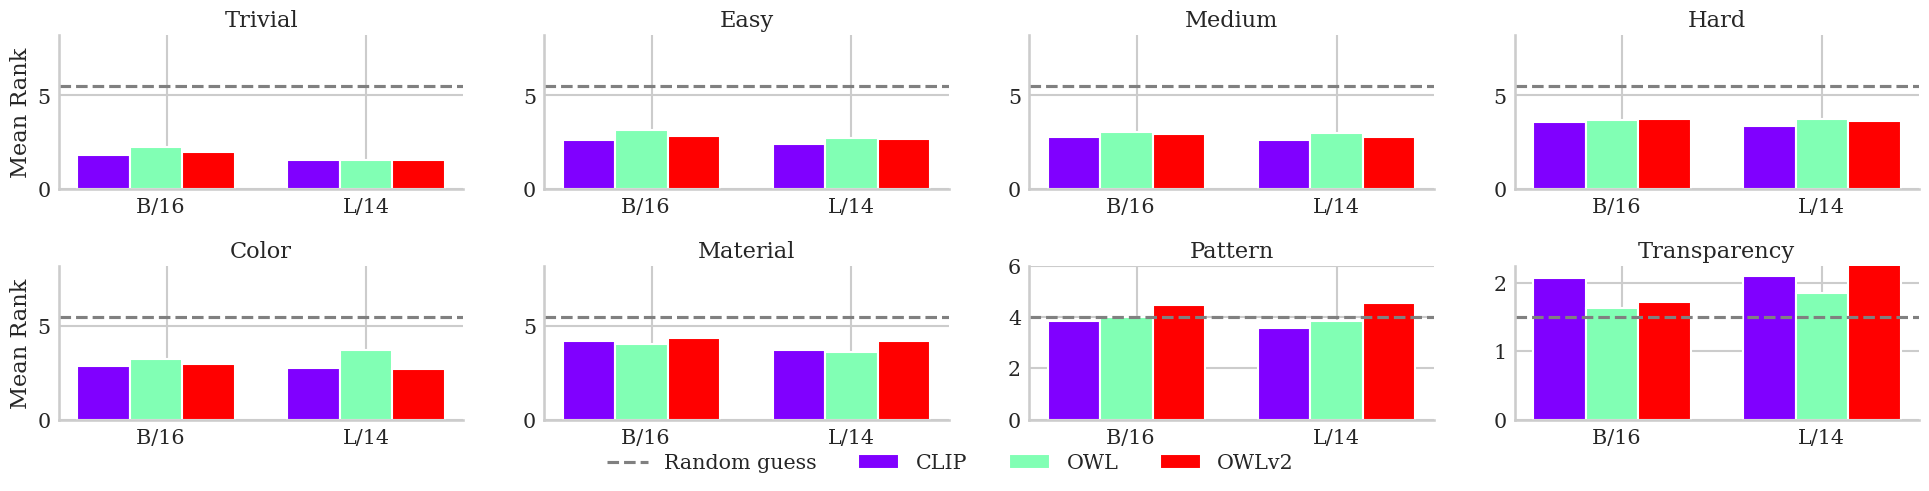

In [18]:
def plot_bar_chart(ax, data_dict, bench, baseline=None, ylabel=False):
    # Extract keys and values from the dictionary
    keys = list(data_dict[bench].keys())
    keys = [k.replace(' B/16', '') if 'B/16' in k else k.replace(' L/14', '') for k in keys]
    values = list(data_dict[bench].values())
    
    # Color palette
    palette = matplotlib.colormaps.get_cmap('rainbow')
    palette = [palette(i) for i in np.linspace(0, 1, len(keys) // 2)]
    # palette = [palette[0] if 'B/16' in key else palette[1] for key in keys]
    palette = [palette[i % (len(keys) // 2)] for i in range(len(keys))]
    
    # Add baseline parameter and horizontal line
    if baseline is not None:
        ax.axhline(y=baseline, color='gray', linestyle='--', label='Random guess')
        
    # Plotting the bar chart
    if ylabel:
        ax.set_ylabel('Mean Rank')
    # hatches = ['', '///', '---'] * 2 if len(keys) == 6 else ['', '///'] * 2
    # hatches = [''] * 3 + ['////'] * 3
    hatches = ''
    # Calculate the bar width
    bar_width = 1
    
    # Adjust x-coordinates for space separation
    x_positions = np.arange(len(keys)) + np.arange(len(keys)) // (len(keys) // 2) * bar_width
    # # Update group labels and positions based on baseline presence
    # if baseline is not None:
    #     group_labels = ['B/16  ', f'L/14 ({baseline})']
    #     label_distance = 4.3  # Adjust based on baseline label length
    ax.bar(x_positions, values, width=bar_width, color=palette, hatch=hatches, label=keys)
    
    ylim = baseline + baseline * 0.5 if baseline is not None else 5
    ax.set_ylim(0, ylim)
    ax.set_title(bench)
    
    # Remove xticks
    ax.set_xticks([])
    
    # Add x-axis labels for the two groups of bars
    group_labels = ['B/16  ', 'L/14']
    label_distance = 3.8
    group_positions = np.arange(2) * label_distance + 1.2
    ax.set_xticks(group_positions)
    ax.set_xticklabels(group_labels)
    ax.tick_params(pad=-3)
    
def plot_bar_chart_grid(mediums, path):
    rescale = True
    width = 24 if rescale else 30
    height = 5
    # sns.set_theme(style='whitegrid', palette='Set3', context='poster')
    sns.set_theme(style="whitegrid", context="talk", font='serif', font_scale=0.9, rc={'text.usetex': False, 'text.latex.preamble': r'\usepackage{underscore}'})
    fig, axes = plt.subplots(2, 4, figsize=(width, height), gridspec_kw={'hspace': 0.5})
    for i, bench in enumerate(benchs.values()):
        row = i // 4
        col = i % 4
        ylabel = col == 0
        if bench == 'Transparency':
            baseline = 3 / 2
        elif bench == 'Pattern':
            baseline = 8 / 2
        else:
            baseline = 11 / 2
        
        plot_bar_chart(axes[row, col], mediums, bench, baseline=baseline, ylabel=ylabel)
    x_off = -0.5 if len(mediums['Trivial']) == 6 else -0.3
    labels = ['Random guess', 'CLIP', 'OWL', 'OWLv2']
    plt.legend(loc="best", bbox_to_anchor=(x_off, -0.1), ncols=len(mediums['Trivial']) + 1, frameon=False, labels=labels)
    sns.despine()
    plt.savefig(path, bbox_inches='tight',format='pdf')

plot_bar_chart_grid(mediums, path='CLIP_vs_OWL.pdf')

# Model Results

In [32]:
def invert_rk(results):
    for k, res in results.items():
        for rk in ['r1', 'r5', 'r10']:
            tmp = res[rk]
            res[rk] = res[f'{rk}i']
            res[f'{rk}i'] = tmp
            
    print(json.dumps(results, indent=4))

In [37]:
with open('triplet_dot.json', 'r') as f:
    results = json.load(f)
warmup = 'Warmup '
fgovd = '+FG-OVD '
warmup_config = 'triplet'
fgovd_config = 'fg-ovd_tr'
n_digits = 1
mean_rank_col = 'Mean Rank Sum'
old2new_keys = {
    'CLIP B/16': f"CLIP B/16",
    f'{warmup_config}_linear-mlp': f"{warmup}linear projection",
    f'{fgovd_config}_linear-mlp': f"{fgovd}linear projection",
    f'{warmup_config}_linear-mlp_te-freezed': f"{warmup}linear projection (only visual)",
    f'{fgovd_config}_linear-mlp_te-freezed': f"{fgovd}linear projection (only visual)",
    f'{warmup_config}_linear-mlp_ve-freezed': f"{warmup}linear projection (only text)",
    f'{fgovd_config}_linear-mlp_ve-freezed': f"{fgovd}linear projection (only text)",
    f'{warmup_config}_non-linear-mlp': f"{warmup}MLPs",
    f'{fgovd_config}_non-linear-mlp': f"{fgovd}MLPs",
    f'{warmup_config}_attention': f"{warmup}attention",
    f'{fgovd_config}_attention': f"{fgovd}attention",
}
results = {new_key: results[old_key] for old_key, new_key in old2new_keys.items()}
df = pd.DataFrame.from_dict(results).transpose()
df = df.round(n_digits)
df

,Mean Rank Sum,r1,r5,r10,r1i,r5i,r10i
CLIP B/16,23.8,41.5,65.9,76.2,22.6,44.1,54.9
Warmup linear projection,27.9,48.5,76.7,85.6,37.6,66.5,77.0
+FG-OVD linear projection,11.6,38.9,67.8,79.3,36.3,64.7,75.6
Warmup linear projection (only visual),25.3,46.3,75.1,84.1,36.4,64.7,75.7
+FG-OVD linear projection (only visual),12.2,40.4,70.8,81.0,35.1,63.4,74.6
Warmup linear projection (only text),26.6,46.6,74.8,84.7,35.7,64.5,75.7
+FG-OVD linear projection (only text),12.5,40.1,71.0,81.6,34.6,63.3,74.7
Warmup MLPs,28.3,45.7,74.5,84.1,35.8,64.6,76.1
+FG-OVD MLPs,11.5,33.2,61.9,74.0,33.2,61.9,73.5
Warmup attention,32.7,36.3,66.1,78.1,29.1,57.6,70.3


In [38]:
# calculating deltas for FG from Warmup
deltas = {}
for index, row in df.iterrows():
    if fgovd in index:
        warmup_row = index.replace(fgovd, warmup)
        deltas[index] = {}
        for col, val in row.items():
            deltas[index][col] = round(val - df.loc[warmup_row, col], n_digits)

# calculating besta value for column
tgt_idxs = {}
for col in df.columns:
    tgt_val = df[col].min() if col == mean_rank_col else df[col].max()
    tgt_idxs[col] = df[df[col] == tgt_val].index

# converting to string
df = df.astype(str)

# adding deltas with proper color
for row, col_vals in deltas.items():
    for col, val in col_vals.items():
        if val == 0:
            continue
        delta = f"+{str(val)}" if val > 0 else str(val)
        color = '{red}' if (val > 0 and col == mean_rank_col) or (val < 0 and col != mean_rank_col) else '{green}'
        df.loc[row, col] = df.loc[row, col] + f"\\textcolor{color}{{({delta})}}"

# making best of columns bold
for col, rows in tgt_idxs.items():
    for row in rows:
        df.loc[row, col] = '\\textbf{%s}' % df.loc[row, col]

# refine column names
old2new_columns = {
    'Mean Rank Sum' : 'FG Mean Rank Sum$\\downarrow$',
    'r1': 'r1$\\uparrow$',
    'r5': 'r5$\\uparrow$',
    'r10': 'r10$\\uparrow$',
    'r1i': 'r1i$\\uparrow$',
    'r5i': 'r5i$\\uparrow$',
    'r10i': 'r10i$\\uparrow$',}
df = df.rename(columns=old2new_columns)
df

,FG Mean Rank Sum$\downarrow$,r1$\uparrow$,r5$\uparrow$,r10$\uparrow$,r1i$\uparrow$,r5i$\uparrow$,r10i$\uparrow$
CLIP B/16,23.8,41.5,65.9,76.2,22.6,44.1,54.9
Warmup linear projection,27.9,\textbf{48.5},\textbf{76.7},\textbf{85.6},\textbf{37.6},\textbf{66.5},\textbf{77.0}
+FG-OVD linear projection,11.6\textcolor{green}{(-16.3)},38.9\textcolor{red}{(-9.6)},67.8\textcolor{red}{(-8.9)},79.3\textcolor{red}{(-6.3)},36.3\textcolor{red}{(-1.3)},64.7\textcolor{red}{(-1.8)},75.6\textcolor{red}{(-1.4)}
Warmup linear projection (only visual),25.3,46.3,75.1,84.1,36.4,64.7,75.7
+FG-OVD linear projection (only visual),12.2\textcolor{green}{(-13.1)},40.4\textcolor{red}{(-5.9)},70.8\textcolor{red}{(-4.3)},81.0\textcolor{red}{(-3.1)},35.1\textcolor{red}{(-1.3)},63.4\textcolor{red}{(-1.3)},74.6\textcolor{red}{(-1.1)}
Warmup linear projection (only text),26.6,46.6,74.8,84.7,35.7,64.5,75.7
+FG-OVD linear projection (only text),12.5\textcolor{green}{(-14.1)},40.1\textcolor{red}{(-6.5)},71.0\textcolor{red}{(-3.8)},81.6\textcolor{red}{(-3.1)},34.6\textcolor{red}{(-1.1)},63.3\textcolor{red}{(-1.2)},74.7\textcolor{red}{(-1.0)}
Warmup MLPs,28.3,45.7,74.5,84.1,35.8,64.6,76.1
+FG-OVD MLPs,\textbf{11.5\textcolor{green}{(-16.8)}},33.2\textcolor{red}{(-12.5)},61.9\textcolor{red}{(-12.6)},74.0\textcolor{red}{(-10.1)},33.2\textcolor{red}{(-2.6)},61.9\textcolor{red}{(-2.7)},73.5\textcolor{red}{(-2.6)}
Warmup attention,32.7,36.3,66.1,78.1,29.1,57.6,70.3


In [39]:
def refine_latex(df):
    latex = df.to_latex(escape=False, caption='Results of different architectures on Fine-grained dataset and on COCO', label='tab:results')
    
    # add centering
    latex = latex.replace('\\begin{table}', '\\begin{table}\n\\centering')
    
    # add hdashline
    latex = latex.replace('Warmup', '\\hline\nWarmup')
    # multiline table
    latex = latex.replace('table', 'table*')
    return latex

print(refine_latex(df))

\begin{table*}
\centering
\caption{Results of different architectures on Fine-grained dataset and on COCO}
\label{tab:results}
\begin{tabular}{llllllll}
\toprule
 & FG Mean Rank Sum$\downarrow$ & r1$\uparrow$ & r5$\uparrow$ & r10$\uparrow$ & r1i$\uparrow$ & r5i$\uparrow$ & r10i$\uparrow$ \\
\midrule
CLIP B/16 & 23.8 & 41.5 & 65.9 & 76.2 & 22.6 & 44.1 & 54.9 \\
\hline
Warmup linear projection & 27.9 & \textbf{48.5} & \textbf{76.7} & \textbf{85.6} & \textbf{37.6} & \textbf{66.5} & \textbf{77.0} \\
+FG-OVD linear projection & 11.6\textcolor{green}{(-16.3)} & 38.9\textcolor{red}{(-9.6)} & 67.8\textcolor{red}{(-8.9)} & 79.3\textcolor{red}{(-6.3)} & 36.3\textcolor{red}{(-1.3)} & 64.7\textcolor{red}{(-1.8)} & 75.6\textcolor{red}{(-1.4)} \\
\hline
Warmup linear projection (only visual) & 25.3 & 46.3 & 75.1 & 84.1 & 36.4 & 64.7 & 75.7 \\
+FG-OVD linear projection (only visual) & 12.2\textcolor{green}{(-13.1)} & 40.4\textcolor{red}{(-5.9)} & 70.8\textcolor{red}{(-4.3)} & 81.0\textcolor{red}{(-3.